## Dataset generation

The script for generating the descriptive statistics of the featuremaps resulting from the inference of the COCO dataset on the model can be found at the following link:

<a href="https://github.com/andics/maskrcnn-combined-build/tree/master/EXPERIMENTS/complete_crop_dataset_rec_featuremaps_var">https://github.com/andics/maskrcnn-combined-build/tree/master/EXPERIMENTS/complete_crop_dataset_rec_featuremaps_var</a>

The dataset of tensors (generated by COCO images), used for the analysis, can be found here:
<a href="https://drive.google.com/file/d/1bNU1M6ZKd9XDkn5o1X0wevo3cTO-WO_N/view?usp=share_link">https://drive.google.com/file/d/1bNU1M6ZKd9XDkn5o1X0wevo3cTO-WO_N/view?usp=share_link</a>

## Importing packages

In [19]:
import os
import itertools
import heapq
import torch
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Defining static variables & Auxiliary functions

In [20]:
dataset_location = "Q:/University/Bocconi/SEM_4/ML/Individual_project/dataset/trial_1_shifted_0.02_0.33_centered_0.52_0.83_layer3_compressed_conv/"

_colnames = ["mean", "median", "max", "st_dev"]
colnames = [f"{col}{i}" for i, col in list(itertools.product(range(1024), _colnames))]
colnames.append("label")
data = pd.DataFrame(columns=colnames)

def prep_datum(datum,i):
  datum = np.array(datum)
  datum = np.concatenate(np.concatenate(datum))
  datum = np.append(datum, i)
  datum = list(datum)
  datum = [v for i, v in enumerate(datum)]
  return datum

Since the following computations take a very long time on my machine, I will work with a reduced version of the _5000x4097_ original dataset, but taking a _500x4097_ sample size from it.

In [21]:
# loop through folders, read .pth files, and append them to the dataframe
inputs = os.listdir(dataset_location)[0:500]
for i, input in enumerate(inputs):
  try:
    i % 50 == 0 and print(f"{i} / {len(inputs)}")
    if(not input.isdigit()):
      continue
    j = int(i%2==0)
    datum = torch.load(os.path.join(dataset_location, f'{input}/predictions_{j}.pth'))
    datum = prep_datum(datum, j)
    data = data.append(pd.DataFrame([datum],columns=colnames),
              ignore_index = True)
  except:
      breakpoint()

data_reduced = data

0 / 500
50 / 500
100 / 500
150 / 500
200 / 500
250 / 500
300 / 500
350 / 500
400 / 500
450 / 500


In [22]:
# See if dataset was loaded correctly
data_reduced.head()

,mean0,median0,max0,st_dev0,mean1,median1,max1,st_dev1,mean2,median2,...,st_dev1021,mean1022,median1022,max1022,st_dev1022,mean1023,median1023,max1023,st_dev1023,label
0,0.021905,0.004727,0.269914,0.048652,-0.035284,-0.020783,0.134004,0.041027,-0.016136,-0.005370,...,0.018781,-0.014061,-0.007147,0.029481,0.018927,-0.029946,-0.016766,0.015294,0.034373,1.0
1,0.018167,0.000388,0.224864,0.051469,-0.036332,-0.019951,0.056164,0.040253,-0.017953,-0.006660,...,0.021032,-0.013839,-0.007130,0.031909,0.018280,-0.035041,-0.024192,0.007149,0.033993,0.0
2,0.021461,0.002417,0.251462,0.047440,-0.036134,-0.021915,0.073211,0.037318,-0.017209,-0.007699,...,0.018982,-0.014333,-0.007157,0.044902,0.018433,-0.031146,-0.020476,0.004837,0.032347,1.0
3,0.020176,0.001669,0.243782,0.045409,-0.033213,-0.019536,0.077464,0.036801,-0.014440,-0.004776,...,0.018056,-0.012851,-0.006721,0.022727,0.017196,-0.028759,-0.017806,0.009733,0.031002,0.0
4,0.011379,-0.001493,0.246806,0.043547,-0.035187,-0.021927,0.042744,0.032398,-0.015570,-0.006282,...,0.017176,-0.010533,-0.005891,0.039205,0.015680,-0.031362,-0.022174,0.005516,0.028750,1.0


## Data normalization: in preparation for PCA

In [23]:
# Step 1: Normalize each column to mean 0 and std 1
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data_reduced.iloc[:, :-1]), columns=data_reduced.columns[:-1])
# Check if variance of columns is indeed 1 and mean 0, as it should be (exclude rounding errors)
assert all(round(df_normalized.var()) == 1)
assert all(round(df_normalized.mean()) == 0)

Length of basis vectors: [[1.]
 [1.]]


[Text(0.5, 1.0, 'PCA Projection of the Data')]

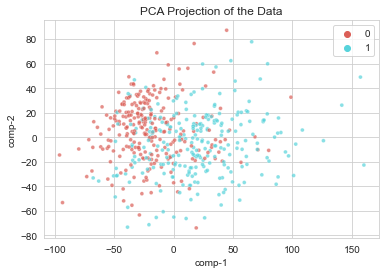

In [24]:
# Step 2: Perform PCA on the normalized dataframe
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized)

# Step 3: Ensure we have found unit-length basis vectors
print(f"Length of basis vectors: {np.sum(pca.components_**2, axis=1, keepdims=True)}")

labels = [0 if value == 0 else 1 for value in data_reduced.iloc[:, -1]]
df_for_display = pd.DataFrame()
df_for_display['y'] = labels
df_for_display['comp-1'] = pca_result[:, 0]
df_for_display['comp-2'] = pca_result[:, 1]

# Step 4: Plot the reduced dataset with colored datapoints
sns.scatterplot(x="comp-1", y="comp-2", hue=df_for_display.y.tolist(),
                palette=sns.color_palette("hls", 2), alpha = 0.7, s=15,
                data=df_for_display).set(title="PCA Projection of the Data")

### Remarks

It seems that with a dimensionality reduction technique such as PCA we do not get very clearly defined clusters for the datapoints. This is somewhat expected, since the high-level statistics descriptive of the neuronal activations could have maximal variance simply depending on the class of the image, rather than its resolution.

Next, we will try a different, more recently developed technique, and frequently used in similar contexts: _T-distributed Stochastic Neighbor Embedding (TSNE)_.

## T-distributed Stochastic Neighbor Embedding (TSNE)

Before applying TSNE, we should reduce the dimension of our data, since the 4096 dimensions of our original dataset are disproportional to the number of datapoints we have, and also TSNE is computationally expensive.

In [25]:
n_dim = 20

pca_n_dim = PCA(n_components=n_dim)
pca_n_dim_result = pca_n_dim.fit_transform(df_normalized)

df_n_dim_PCAed_data = pd.DataFrame()
for i in range(n_dim):
    df_n_dim_PCAed_data[f'comp-{i+1}'] = pca_n_dim_result[:, i]
df_n_dim_PCAed_data['y'] = labels

Explore TSNE visualizations using various hyperparameters.

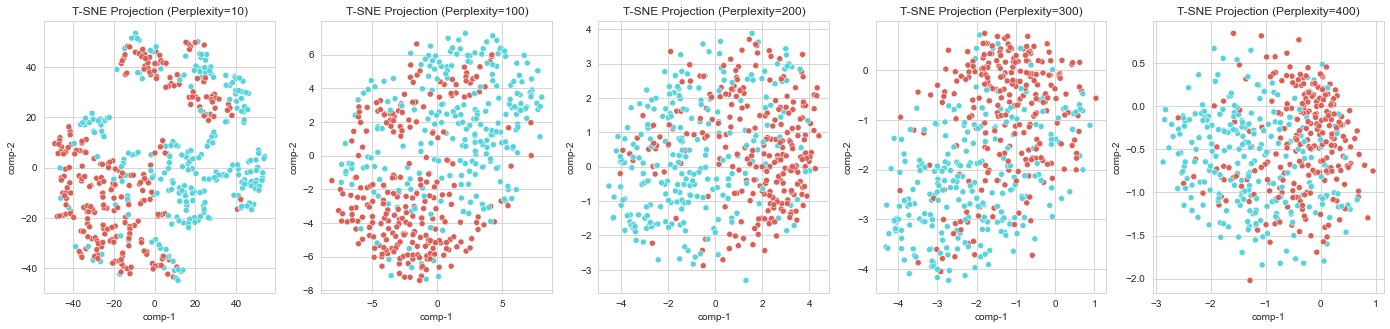

In [26]:
# Define a list of perplexity values to loop over
perplexities = [10, 100, 200, 300, 400]

# Create an empty figure with subplots for each perplexity value
fig, axes = plt.subplots(nrows=1, ncols=len(perplexities), figsize=(24, 5))

# Loop over each perplexity value, create a TSNE projection, and plot the result
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, verbose=False, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(df_n_dim_PCAed_data.iloc[:, :-1])
    tsne_projected_data = pd.DataFrame({'comp-1': tsne_result[:, 0],
                                        'comp-2': tsne_result[:, 1],
                                        'y': df_n_dim_PCAed_data.iloc[:, -1]})
    sns.scatterplot(ax=axes[i], x="comp-1", y="comp-2", hue="y", palette=sns.color_palette("hls", 2),
                    data=tsne_projected_data).set(title=f"T-SNE Projection (Perplexity={perplexity})")
    axes[i].legend().remove()

# Show the plots
plt.show()

### Unsupervised Cluster Analysis - conclusions

Nor-linear dimensionality reduction (such as TSNE) seems to be more capable of capturing the underlying resolution-based clusters. It seems larger preplexity values are more appropriate and, with more computational power, one could attempt the same experiment using more PCA components as a pre-processing base for the data. This will likely lead to more clearly defined clusters.

## Logistic regression for cluster identification (supervised)

We proceed with using Logistic regression for discerning vectors coming from type 0 and type 1 resolutions. We begin by dropping the _Median_ neuronal activation predictor, since it is more difficult to interpret, highly correlated with _Mean_, and empirical studies mainly utilize the other predictors in our dataset. This also significantly reduces the amount of computations we need to perform.

In [27]:
# split the data
features = [col for col in colnames[:-1] if col[:3] != "med"]
for col in colnames:
  col[:3] == "med" and data.drop(columns=col, inplace=True)

X = data_reduced[features]
y = data_reduced.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=16)

In [28]:
# train the model
logreg = LogisticRegression(random_state=16, max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=16)

In [29]:
# evaluate the model oos
y_pred = logreg.predict(X_test)
cnf = metrics.confusion_matrix(y_test, y_pred)
score = logreg.score(X_test, y_test)
print(cnf, score)

[[108  16]
 [ 25 101]] 0.836


### Z-Test as a proxy for distribution difference

Running the Z-Test, described in the supplementary paper, which is used as a proxy for confirming whether Resolution 0 and Resolution 1 vectors come from different distributions.

In [30]:
# compute t statistic
te0 = cnf[0][1] + cnf[1][1]
te1 = cnf[1][0] + cnf[0][0]
e0 = cnf[0][1] / te0
e1 = cnf[1][0] / te1
e = (e0 + e1)/2
t0 = e0 * (1-e0) / te0
t1 = e1 * (1-e1) / te1
t = (2*e-1)/((t0 + t1)**(1/2))
t

-14.541011614776616

In [31]:
# run Z test
alpha = .01
thresh = -st.norm.ppf(1-alpha)
t < thresh

True

### Visualizing key predictors

We visualize the top predictors, as based on absolute values in the regression coefficients.

In [32]:
# get mean, max coeffs
coef = logreg.coef_[0].tolist()
mean, max = pd.Series(coef[::2]), pd.Series(coef[1::2])

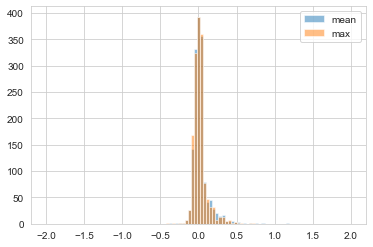

In [33]:
# show distribution of mean and max coeffs
bins = np.linspace(-2, 2, 100)
plt.hist(mean, bins, alpha=0.5, label='mean')
plt.hist(max, bins, alpha=0.5, label='max')
plt.legend(loc='upper right')
plt.show()

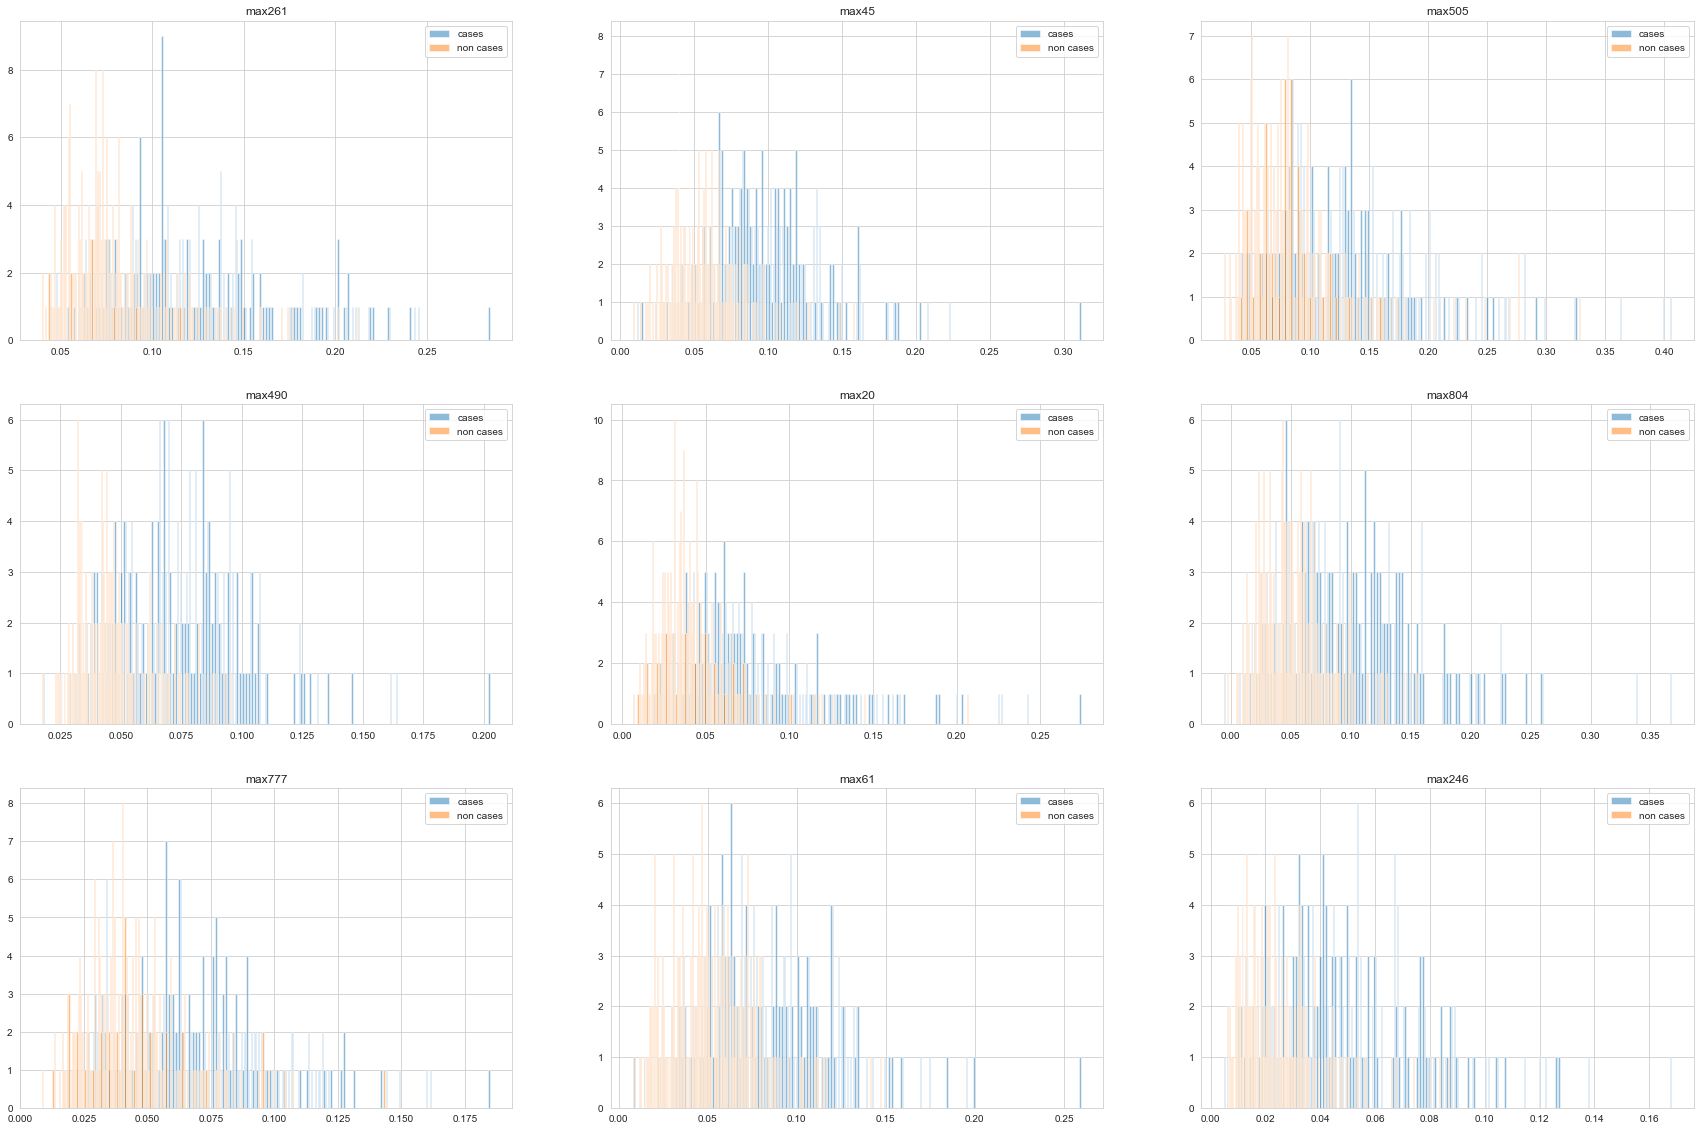

In [34]:
n=9
coef = [abs(c) for c in coef]
top_n = heapq.nlargest(n, range(len(coef)), coef.__getitem__)
top_n = data_reduced.columns[top_n]

fig, axs = plt.subplots(3, 3, figsize=(30,20))
a = axs.ravel()

for idx,ax in enumerate(a):
    col = top_n[idx]
    cases = data_reduced[data_reduced.label == 1.0][col]
    non_cases = data_reduced[data_reduced.label == 0.0][col]
    ax.hist(cases, bins=300, alpha=0.5, label='cases')
    ax.hist(non_cases, bins=300, alpha=0.5, label='non cases')
    ax.legend(loc='upper right')
    ax.set_title(col)

### Remarks (supervised)

The Logistic regression model passed the Z-test easily, confirming that indeed tensors of type 0 and type 1 resolutions are drawn from different distributions.

## Conclusions

Unsupervised non-linear methods seem to be able to capture the intrinsic difference betwwen the activations, depending on resolution (see TSNE). Linear ones, however, seem to be more limited (see PCA).
For supervised methods, on the other hand, even linearity is already enough, as we just demonstrated with the Logistic regression classifier.

With a high-level overview, we conclude that neurons do seem to specialize in the resolution they tackle, as confirmed to a limited degree by unsupervised techniques also.
As a next step, with more computational power, one could perform similar analysis but using more samples and components in TSNE.